## Scikit-Learn by Isha Borgaonkar 

In [1]:
# Verify versions
import pkg_resources
print("scikit-learn:", pkg_resources.get_distribution("scikit-learn").version)
print("pandas:     ", pkg_resources.get_distribution("pandas").version)


scikit-learn: 1.5.2
pandas:      2.3.0


## Data Loading & Preprocessing

In [3]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) Load the Iris dataset
iris = datasets.load_iris()
X, y = iris.data, iris.target  # X: feature matrix (150×4), y: labels (150,)

# 2) Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # 20% test, reproducible
)

# 3) Scale features to zero mean, unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Learn µ/σ on train
X_test_scaled  = scaler.transform(X_test)       # Apply same transform to test


## Classification Example

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1) Initialize a logistic regression classifier
clf = LogisticRegression(random_state=42)

# 2) Train on scaled data
clf.fit(X_train_scaled, y_train)

# 3) Predict on test set
y_pred = clf.predict(X_test_scaled)

# 4) Evaluate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# 5) Detailed metrics
print(classification_report(y_test, y_pred, target_names=iris.target_names))


Test Accuracy: 1.0000
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Regression Example

In [7]:
from sklearn.datasets import fetch_california_housing   # Replacement for the removed load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) Load the California Housing dataset
cal_housing = fetch_california_housing()
Xr, yr = cal_housing.data, cal_housing.target  # Xr: features, yr: median house values

# 2) Split into train/test sets
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr,
    test_size=0.2,
    random_state=0
)

# 3) Standardize features to zero mean and unit variance
scaler_r = StandardScaler()
Xr_train_s = scaler_r.fit_transform(Xr_train)  # Learn scaling on train
Xr_test_s  = scaler_r.transform(Xr_test)       # Apply same scaling to test

# 4) Train a linear regression model
reg = LinearRegression()
reg.fit(Xr_train_s, yr_train)

# 5) Predict on test set and compute RMSE
yr_pred = reg.predict(Xr_test_s)
rmse = np.sqrt(mean_squared_error(yr_test, yr_pred))
print(f"Test RMSE: {rmse:.2f}")


Test RMSE: 0.73


 ## Clustering & Outlier Detection

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.ensemble import IsolationForest

# -- KMeans clustering on Digits dataset --
digits = datasets.load_digits()
Xd = StandardScaler().fit_transform(digits.data)

kmeans = KMeans(n_clusters=10, random_state=0)
labels = kmeans.fit_predict(Xd)
ari = adjusted_rand_score(digits.target, labels)
print(f"Adjusted Rand Index: {ari:.4f}")

# -- IsolationForest for outlier detection --
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(Xd)
print("Number of detected outliers:", (outliers == -1).sum())


Adjusted Rand Index: 0.5593
Number of detected outliers: 18


## Pipelines & Hyperparameter Tuning

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 1) Build a pipeline: scaler + classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=1))
])

# 2) Define parameter grid
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5, 10]
}

# 3) Grid search with 5-fold CV
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Best params: {'rf__max_depth': None, 'rf__n_estimators': 50}
Best CV accuracy: 0.9666666666666668


## Cross-Validation & Custom Scoring

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Build a pipeline that scales the data then fits LogisticRegression
pipe = make_pipeline(
    StandardScaler(),                         # Scale features to zero mean, unit variance
    LogisticRegression(
        solver='lbfgs', 
        max_iter=1000,                        # Increase iterations for convergence
        random_state=42
    )
)

# Perform 5-fold CV with macro F1 score
f1_scores = cross_val_score(
    pipe,                                     # Pipeline instead of bare estimator
    X, y,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1                                 # Parallelize across CPU cores
)

print("F1 scores per fold:", f1_scores)
print("Mean F1 score:       ", f1_scores.mean().round(4))


F1 scores per fold: [0.96658312 1.         0.93265993 0.89974937 1.        ]
Mean F1 score:        0.9598


## Custom Transformer

In [16]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import numpy as np

# Custom transformer that applies log1p to features
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.log1p(X)

# Build a pipeline with:
# 1) LogTransformer to stabilize variance
# 2) StandardScaler to zero‐mean/unit‐variance features
# 3) SVC classifier
pipe2 = Pipeline([
    ('log',    LogTransformer()),    # Apply log(1 + x)
    ('scaler', StandardScaler()),    # Scale features
    ('svc',    SVC(kernel='rbf',     # Radial basis function kernel
                     C=1.0,          # Regularization parameter
                     gamma='scale',  # Kernel coefficient
                     random_state=42
    ))
])

# Now you can fit and predict:
pipe2.fit(X_train, y_train)
y_pred = pipe2.predict(X_test)


## Feature Selection

In [20]:
from sklearn.feature_selection import SelectKBest, f_classif

# Iris has 4 features, so pick k=2 instead of 5
selector = SelectKBest(score_func=f_classif, k=2)  
X_selected = selector.fit_transform(X, y)

print("Original feature shape:", X.shape)
print("Selected feature shape:", X_selected.shape)


Original feature shape: (150, 4)
Selected feature shape: (150, 2)


## Handling Imbalanced Data

In [21]:
from sklearn.utils import resample

# Upsample minority class in train set
X_min = X_train[y_train == 1]
y_min = y_train[y_train == 1]
X_maj = X_train[y_train == 0]
y_maj = y_train[y_train == 0]

X_min_up, y_min_up = resample(
    X_min, y_min,
    replace=True,
    n_samples=len(y_maj),
    random_state=42
)

X_bal = np.vstack([X_maj, X_min_up])
y_bal = np.hstack([y_maj, y_min_up])


## Ensemble Methods

## Bagging 

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load data and split
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Initialize BaggingClassifier with DecisionTreeClassifier as the base learner
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # Note: use `estimator=` instead of `base_estimator=`
    n_estimators=10,                     # Number of trees in the ensemble
    random_state=42
)

# Train and evaluate
bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)
print("Bagging Accuracy:", accuracy_score(y_test, y_pred))


Bagging Accuracy: 1.0


In [28]:
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

# 1) Load data and split
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 2) Boosting with AdaBoost
# - estimator=DecisionTreeClassifier() as weak learner
# - n_estimators: number of boosting rounds
boost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  
    n_estimators=50,                     
    learning_rate=1.0,
    random_state=42
)
boost.fit(X_train, y_train)
y_pred_boost = boost.predict(X_test)
print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred_boost))

# 3) Stacking Ensemble
# - estimators: list of (name, estimator) tuples
# - final_estimator: meta-learner to combine base predictions
stack = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=500, random_state=42)),
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1,
    passthrough=False   # If True, also pass original features to final estimator
)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
print("Stacking Accuracy:", accuracy_score(y_test, y_pred_stack))

# 4) Model Persistence with joblib
# Save both models and the train/test split for later use
joblib.dump({
    'scaler': None,            # include scaler if you used one
    'boost_model': boost,
    'stack_model': stack
}, 'ensemble_models.pkl')

# Later, to load:
saved = joblib.load('ensemble_models.pkl')
loaded_boost = saved['boost_model']
loaded_stack = saved['stack_model']

# Verify loaded models
print("Loaded AdaBoost Accuracy:", accuracy_score(y_test, loaded_boost.predict(X_test)))
print("Loaded Stacking Accuracy:", accuracy_score(y_test, loaded_stack.predict(X_test)))


C:\Users\ISHA\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 1.0
Stacking Accuracy: 1.0
Loaded AdaBoost Accuracy: 1.0
Loaded Stacking Accuracy: 1.0


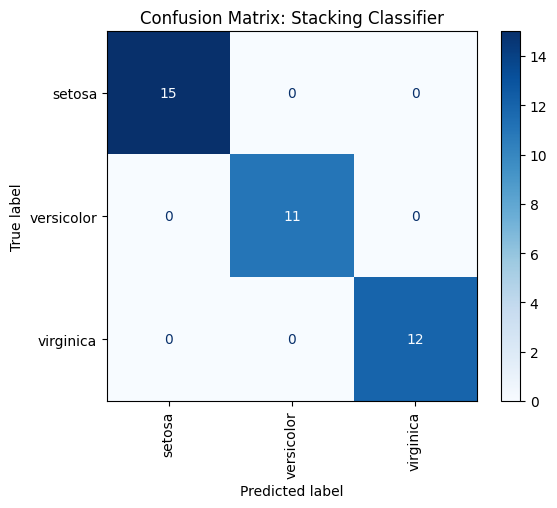

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Assume you have test labels y_test and predictions y_pred_stack from the stacking model

# 1) Confusion Matrix for the Stacking Classifier
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix: Stacking Classifier")
plt.show()



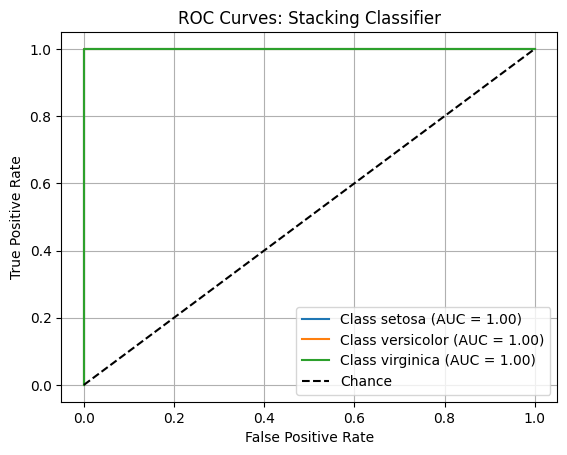

In [31]:
# 2) ROC Curves for a One-vs-Rest multiclass setup
# Binarize the output
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_score = stack.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {iris.target_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.title("ROC Curves: Stacking Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


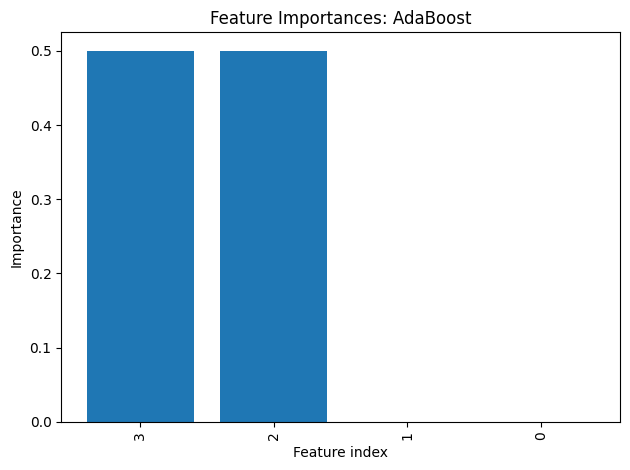

7

In [32]:
# 3) Feature Importances from the AdaBoost model
importances = boost.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), indices, rotation='vertical')
plt.title("Feature Importances: AdaBoost")
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
7